In [54]:
import tensorflow as tf
import math 
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

%matplotlib inline

In [10]:
#导入数据
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")#训练集
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_signs.h5', "r")#测试集
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [11]:
#图片显示
def image_show(index, dataset):
    index = index
    if dataset == "train":
        plt.imshow(X_train_orig[index])
        print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
    elif dataset == "test":
        plt.imshow(X_test_orig[index])
        print ("y = " + str(np.squeeze(Y_test_orig[:, index])))

In [45]:
#ong-hot编码
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T#np.eye():生成单位矩阵
    return Y

In [46]:
#创建X，Y的占位符
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X, Y

In [47]:
#参数W进行xavier初始化，b初始化为0
def initialize_parameters():
    tf.set_random_seed(1) 
    
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [48]:
#前向传播
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                           
    A1 = tf.nn.relu(Z1)                                             
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
    A2 = tf.nn.relu(Z2)                                            
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                               
    
    return Z3

In [49]:
#成本计算
def compute_cost(Z3, Y):

    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [50]:
#随机小批量
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[1]            
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    num_complete_minibatches = math.floor(m/mini_batch_size)#小批量数量
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:#剩余的小批量
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [51]:
#计算准确率
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

In [56]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()  #使重新运行时不覆盖tf的变量
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        

    X, Y = create_placeholders(n_x, n_y) #占位符
    parameters = initialize_parameters() #初始化参数
    Z3 = forward_propagation(X, parameters) #前向传播
    cost = compute_cost(Z3, Y) #损失计算
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) #使用Adam梯度下降
    
    init = tf.global_variables_initializer() #变量初始化

    with tf.Session() as sess:
        
        sess.run(init) #运行变量初始化

        for epoch in range(num_epochs): 

            epoch_cost = 0. #每epoch一次后的成本值
            num_minibatches = int(m / minibatch_size) #小批量数目
            seed = seed + 1 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed) #随机小批量

            for minibatch in minibatches: 
                
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("%i epoch 后的成本值 : %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("参数训练完毕")

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("训练集准确度:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("测试集准确度:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

0 epoch 后的成本值 : 1.855702
100 epoch 后的成本值 : 1.016458
200 epoch 后的成本值 : 0.733102
300 epoch 后的成本值 : 0.572940
400 epoch 后的成本值 : 0.468774
500 epoch 后的成本值 : 0.381021
600 epoch 后的成本值 : 0.313822
700 epoch 后的成本值 : 0.254158
800 epoch 后的成本值 : 0.203829
900 epoch 后的成本值 : 0.166421
1000 epoch 后的成本值 : 0.141486
1100 epoch 后的成本值 : 0.107580
1200 epoch 后的成本值 : 0.086270
1300 epoch 后的成本值 : 0.059371
1400 epoch 后的成本值 : 0.052228


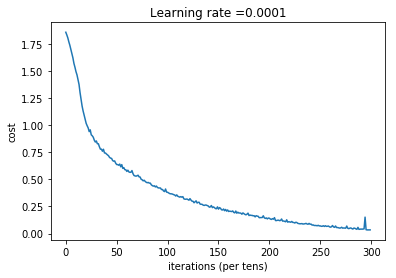

参数训练完毕
训练集准确度: 0.999074
测试集准确度: 0.716667


In [57]:
#数据集处理
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T #转置
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flatten/255. #标准化
X_test = X_test_flatten/255.
Y_train = convert_to_one_hot(Y_train_orig, 6) #变为one-hot形式
Y_test = convert_to_one_hot(Y_test_orig, 6)

parameters = model(X_train, Y_train, X_test, Y_test)

Your algorithm predicts: y = 3


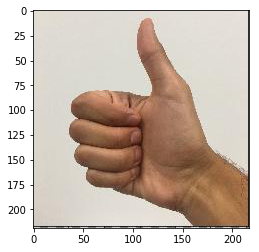

In [59]:
import scipy
from PIL import Image
from scipy import ndimage

fname = "thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))